# **Example 1: CentralPeak Test**

The following example demonstrates how to run CentralPeak Test for Neural Power Spectum models and empirical data. The test determines if a peak is present within a specified frequency range in the neural power spectum of interest.

**Installation of SciUnit and FOOOF**

In [ ]:
# If running in colab, uncomment
#!pip install -q sciunit
#!pip install fooof
#!pip install wget

**Import all library and modules necessary for the example**




In [ ]:
%matplotlib inline
import sciunit
from fooofunit import capabilities, models, scores, tests
from fooof import FOOOF
import wget

import os,sys,glob, numpy as np, pandas as pd
from matplotlib import pyplot as plt
from scipy.io import loadmat
import seaborn as sns
sns.set()

**Import only capability, models and test of interest**

In [ ]:
from fooofunit.capabilities import ProducesPowerSpectrum
from fooofunit.models import NeuralPowerSpectra
from fooofunit.models import DataModel
from fooofunit.tests import CentralPeak
from fooofunit.utils import common_fr_bands
from fooofunit.io import load_data_mat, visualize_multiple_data

**Generate Simulated Power Spectra**

As an example, a simulated neural power spectrum generated with the FOOOF tool is used. The class GeneratePowerSpectrum allows us to generate this neural power spectrum. The frequency range, the noise, the aperiodic and periodic parameters are defined.

In [ ]:
class GeneratePowerSpectrum:
  
  def __init__(self, freq_range, aperiodic_params, periodic_params, nlv=0):
    from fooof.sim.gen import gen_power_spectrum
    self.freqs, self.spectrum = gen_power_spectrum(freq_range, aperiodic_params, periodic_params,nlv)
    self.freq_range = freq_range

In [ ]:
SimulatedPowerSpectra1 = GeneratePowerSpectrum([3, 40] ,[1, 1], [10, 0.3, 1])

**Empirical Data**

The simulated neural power spectrum is compared against multiple empirical data. In this case, 10 different MEG data is used as the observation. All the data is loaded and the power spectrum is computed:

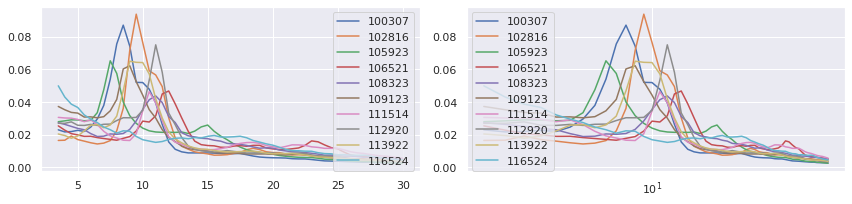

In [ ]:
url = 'https://raw.githubusercontent.com/GriffithsLab/ctwc-model/master/data/S95_MEG.txt'
filename = wget.download(url)
subs = np.loadtxt(filename).astype(int)
subs = np.delete(subs, 2)
all_ps = {}
observation={}
for sub in subs[:10]:
    url = 'https://raw.githubusercontent.com/GriffithsLab/ctwc-model/master/data/%s_MEG_3-Restin_powavg.mat' %sub
    f = wget.download(url)
    observation[sub], all_ps[sub]= load_data_mat(f)

visualize_multiple_data(all_ps)

**DataModel class**

Since we wish to test the empirical data, a DataModel class is used to wrap the data. The enables the data to behave like a model and a frozen data trace is produced. The test will be executed on the data trace.

In [ ]:
data_obs = {}
for key in observation.keys():
  data_obs[key] = DataModel(observation[key]['freqs'], observation[key]['powers'], observation[key]['freq_range'], name="Subject %s"%key)


**NeuralPowerSpectra class**

NeuralPowerSpectra model class is instantiated with the frequency, spectrum and frequency range of the simulated neural power spectrum (model of interest).

In [ ]:
model= NeuralPowerSpectra(SimulatedPowerSpectra1.freqs, SimulatedPowerSpectra1.spectrum, SimulatedPowerSpectra1.freq_range, name="Simulated Power Spectra")


**Parameters: Frequency Band**

The frequency bands of interest need to be defined. The tests are instantiated/parametrized with the frequency ranges. Since we are looking at a neural power spectrum, the frequency bands correspond to categories of brain waves: theta, alpha, beta and gamma. These can be loaded directly with the function common_fr_bands(range)


In [ ]:
#To obtain a resul for every frequency range
bands = common_fr_bands(all)

#Example for only one frequency band. Options are: 'theta', 'alpha', 'beta' and 'gamma

#bands = common_fr_bands_test('alpha')

In [ ]:
bands

{'alpha': [8, 13], 'beta': [13, 30], 'gamma': [30, 50], 'theta': [4, 8]}

**TestSuite and Model/Data List**

Each frequency band corresponds to a different type of test. A test suite with each tests is created:


In [ ]:
band_tests = [CentralPeak(name=key, min_peak = 0.4, band=value)
         for key, value in bands.items()]
band_suite = sciunit.TestSuite(band_tests)

A list of all the model and the data on which the TestSuite will be applied is made: 

In [ ]:
model_and_data = list(data_obs.values())
model_and_data.insert(0, model)

**Judge**

The judge method executes the test and returns a score for the model and data. The score is a boolean score: 'Pass' if a peak is present in the frequency range, 'Fail' otherwise.

In [ ]:
res = band_suite.judge(model_and_data)

**Score**

The results are summarized in a score matrix where each row corresponds to a model or an observation and each column to a frequency range tested. 

In [ ]:
res

,theta,alpha,beta,gamma
Simulated Power Spectra,Fail,Fail,Fail,Fail
Subject 100307,Fail,Pass,Fail,Fail
Subject 102816,Fail,Pass,Fail,Fail
Subject 105923,Pass,Fail,Pass,Fail
Subject 106521,Fail,Pass,Fail,Fail
Subject 108323,Fail,Pass,Fail,Fail
Subject 109123,Fail,Pass,Fail,Fail
Subject 111514,Fail,Pass,Fail,Fail
Subject 112920,Fail,Pass,Fail,Fail
Subject 113922,Fail,Pass,Fail,Fail


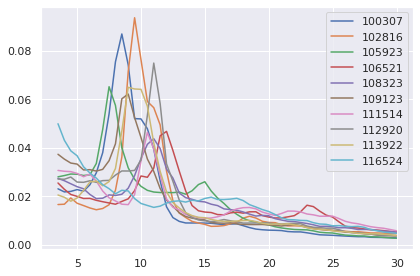

In [ ]:
df_all_ps = pd.concat(all_ps,sort=False)
df_all_ps.mean(axis=1).unstack().T.loc[:30].plot()
plt.tight_layout()

The ScoreMatrix enables us to immediately determine which model and data have the same results and wether a peak exists in the frequency range of interest. 

The next example looks at band and peak power differences between a model and an observation

# **Testing**

In [ ]:
expected_alpha = pd.Series([False, True, True, False, True, True, True, True, True, True, False])
alpha_score = res.score.iloc[:,1]
alpha_score.reset_index(drop=True, inplace=True)
assert expected_alpha.equals(alpha_score)